In [2]:
# Data handling
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Optimisation
import swifter
from scipy.sparse import csr_matrix

# ML
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix

/Users/till/.pyenv/versions/3.10.6/envs/fake-data-detector/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Functions

In [3]:
# Data Loading

def load_data(filepath):
    """Loads data from a CSV file."""
    data = pd.read_csv(filepath, encoding="utf-8")
    df = data.copy()
    df = df.drop(columns=["prompt_id", "text_length", "word_count"])
    df["source"] = df["source"].apply(lambda x: 1 if x != "Human" else 0)
    return df

In [4]:
# Text Cleaning

class TextCleaner(BaseEstimator, TransformerMixin):
    def text_cleaning(self, text, *args):
        # Remove punctuation
        text = text.translate(str.maketrans('', '', string.punctuation))
        # Remove numbers (optional)
        text = re.sub(r'\d+', '', text)
        # Convert to lowercase
        text = text.lower()
        # Remove extra spaces
        text = ' '.join(text.split())
        return text

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        """Apply cleaning to text column."""
        if isinstance(X, pd.DataFrame):
            return X.assign(text=X["text"].apply(self.text_cleaning))  # Clean DataFrame column
        return X.apply(self.text_cleaning)  # Clean Series

In [5]:
# TF-IDF Vectorization

class TFIDFVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, max_features=10000, ngram_range=(1,2), stop_words="english"):
        """
        Custom TF-IDF vectorizer with optimizations.
        - max_features: Limits vocabulary size to the most important words.
        - ngram_range: (1,1) for unigrams, (1,2) for bigrams, etc.
        """
        self.max_features = max_features
        self.ngram_range = ngram_range
        self.stop_words = stop_words
        self.vectorizer = TfidfVectorizer(
            max_features=max_features,
            ngram_range=ngram_range,
            stop_words=stop_words)


    def fit(self, X, y=None):
        """Fit the vectorizer to the text data."""
        if isinstance(X, pd.DataFrame) and "text" in X.columns:
            X = X["text"]
        self.vectorizer.fit(X)
        return self


    def transform(self, X):
        """Transforms text data into TF-IDF feature vectors."""
        if isinstance(X, pd.DataFrame) and "text" in X.columns:
            X = X["text"]
        vec_result = self.vectorizer.transform(X)
        return vec_result.toarray()  # Ensures Output is Numeric

In [6]:
# Model Training

class GradientBoostingClassifierWrapper(BaseEstimator, TransformerMixin):
    def __init__(self, n_estimators=200, learning_rate=0.1, max_depth=3, early_stopping_rounds=10):
        """
        Custom wrapper for Gradient Boosting Classifier.
        - n_estimators: Similar to epochs
        - learning_rate: Shrinks contribution of each tree.
        - max_depth: Maximum depth of individual estimators.
        - early_stopping_rounds: Stops training when validation loss doesn't improve.
        """
        self.model = GradientBoostingClassifier(
            n_estimators = n_estimators,
            learning_rate = learning_rate,
            max_depth = max_depth,
            validation_fraction = 0.1,  # 10% of training data for validation
            n_iter_no_change = early_stopping_rounds)


    def fit(self, X, y):
        """Train Gradient Boosting model."""
        self.model.fit(X, y)
        return self


    def predict(self, X):
        """Predict with the trained Gradient Boosting model."""
        return self.model.predict(X)


    def predict_proba(self, X):
        """Predict class probabilities."""
        return self.model.predict_proba(X)

In [7]:
# Model Evaluation

class EvaluationPipeline:
    def __init__(self, model):
        """Initialize with a trained model."""
        self.model = model
        self.train_acc_history = []
        self.val_acc_history = []

    def track_accuracy(self, X_train, y_train, X_val, y_val):
        """Track training and validation accuracy over epochs."""
        X_train_transformed = self.model.named_steps["tfidf"].transform(
            self.model.named_steps["text_cleaning"].transform(X_train))
        X_val_transformed = self.model.named_steps["tfidf"].transform(
            self.model.named_steps["text_cleaning"].transform(X_val))

        # Ensure accuracy history is cleared before tracking
        self.train_acc_history.clear()
        self.val_acc_history.clear()

        # Track staged predictions
        train_stages = self.model.named_steps["classifier"].model.staged_predict(X_train_transformed)
        val_stages = self.model.named_steps["classifier"].model.staged_predict(X_val_transformed)

        # Initialize best validation accuracy tracking
        best_val_acc = 0.0
        best_epoch = 0

        for epoch, (train_pred, val_pred) in enumerate(zip(train_stages, val_stages), start=1):
            train_acc = accuracy_score(y_train, train_pred)
            val_acc = accuracy_score(y_val, val_pred)

            self.train_acc_history.append(train_acc)
            self.val_acc_history.append(val_acc)

            # Track the best validation accuracy
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_epoch = epoch

        print(f"\nBest Validation Accuracy: {best_val_acc:.4f} at epoch {best_epoch}")


    def evaluate(self, X_test, y_test):
        """Evaluate the trained model on test data."""
        y_pred = self.model.predict(X_test)
        y_pred_proba = self.model.predict_proba(X_test)[:, 1]

        results = {
            "loss": log_loss(y_test, y_pred_proba),
            "accuracy": accuracy_score(y_test, y_pred),
            "precision": precision_score(y_test, y_pred),
            "recall": recall_score(y_test, y_pred),
            "roc_auc": roc_auc_score(y_test, y_pred_proba)}

        # Print performance
        print("Model Performance on Test Set:")
        print(f"Loss: {results['loss']:.4f}")
        print(f"Accuracy: {results['accuracy']:.4f}")
        print(f"Precision: {results['precision']:.4f}")
        print(f"Recall: {results['recall']:.4f}")
        print(f"ROC-AUC: {results['roc_auc']:.4f}")

        # Convergence Plot
        if self.train_acc_history and self.val_acc_history:
            plt.figure(figsize=(5, 4))
            plt.plot(range(1, len(self.train_acc_history) + 1), self.train_acc_history, label="Train Accuracy")
            plt.plot(range(1, len(self.val_acc_history) + 1), self.val_acc_history, label="Validation Accuracy")
            plt.xlabel("Epochs")
            plt.ylabel("Accuracy")
            plt.title("Training vs. Validation Accuracy Over Epochs")
            plt.legend()
            plt.grid()
            plt.show()
        else:
            print("\nWarning: Accuracy history is empty. Ensure `track_accuracy` is called before `evaluate`.")

        # Confusion Matrix Plot
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Human", "AI"], yticklabels=["Human", "AI"])
        plt.xlabel("Predicted Label")
        plt.ylabel("Actual Label")
        plt.title("Confusion Matrix")
        plt.show()

# Pipelines

In [8]:
text_cleaning_pipeline = Pipeline([('clean_text', TextCleaner())])

tfidf_pipeline = Pipeline([
    ("tfidf", TFIDFVectorizer(
        max_features=10000,
        stop_words="english"))])

final_pipeline = Pipeline([
    ("text_cleaning", text_cleaning_pipeline),
    ("tfidf", tfidf_pipeline),
    ("classifier", GradientBoostingClassifierWrapper(n_estimators=300, learning_rate=0.2, max_depth=3, early_stopping_rounds=20))])

evaluator = EvaluationPipeline(model=final_pipeline)

# UI prediction
ui_pred_pipe = Pipeline([
    ("text_cleaning", text_cleaning_pipeline),
    ("tfidf", tfidf_pipeline),
    ("classifier", final_pipeline.named_steps["classifier"])]) # Use trained classifier

In [9]:
# Predict Text (UI)

class TextClassificationModel:
    def __init__(self, pipeline):
        """Wrap the pre-trained pipeline."""
        self.pipeline = pipeline

    def predict_text(self, input_text):
        """Predict a single text input (for UI usage)."""
        if self.pipeline is None:
            raise ValueError("Model has not been initialized properly.")

        # Ensure input is in a DataFrame with 'text' column
        df = pd.DataFrame({"text": [input_text]})

        # Apply preprocessing + prediction
        y_pred = self.pipeline.predict(df)[0]
        y_pred_proba = self.pipeline.predict_proba(df)[:, 1][0]  # Probability of AI class (1)

        # Format probability as percentage
        probability = f"{y_pred_proba * 100:.2f}%"

        return {"Prediction": "AI" if y_pred == 1 else "Human", "AI Probability": probability}

model = TextClassificationModel(ui_pred_pipe)

# Test Use

In [10]:
df = load_data("../../data/10k_sampled_dataset.csv")

df.head()

,text,source
0,"In 1466, perhaps 40,000 people died of the pla...",1
1,Amazon's yet-unnamed Lord of the Rings origina...,1
2,@Holt \n***Hi. I've just rewritten the essay....,0
3,Pleasantly surprised! Had a few options for ve...,1
4,Shakespeare’s Othello: A Tragic Hero Research ...,0


In [11]:
df["source"].value_counts(normalize=True)

source
0    0.5577
1    0.4423
Name: proportion, dtype: float64

Model Performance on Test Set:
Loss: 0.2332
Accuracy: 0.9055
Precision: 0.8677
Recall: 0.9276
ROC-AUC: 0.9642



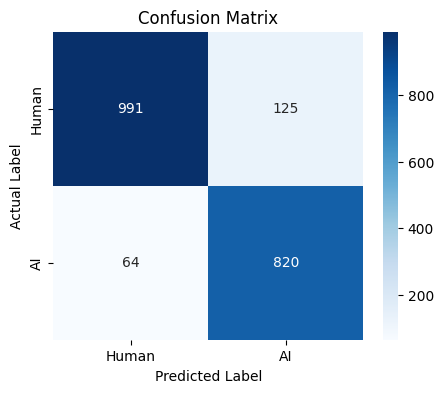

In [12]:
# Train and evaluate

X = df["text"]  # Raw text input
y = df["source"]  # Labels (0=Human, 1=AI)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Model
final_pipeline.fit(X_train, y_train)

# Track Accuracy History (before evaluation)
#evaluator.track_accuracy(X_train, y_train)

# Evaluate Model
results = evaluator.evaluate(X_test, y_test)
results

In [13]:
test01 = "Melbourne, Australia, is renowned for its vibrant and sophisticated coffee culture, often considered one of the best in the world. The city’s laneways are dotted with cozy cafes, each offering meticulously crafted brews that reflect a deep passion for quality and artistry. From flat whites to single-origin pour-overs, Melbourne’s baristas are skilled artisans, dedicated to perfecting every cup. The coffee scene here is more than just a drink—it’s a lifestyle, a social ritual, and a celebration of community. Locals take pride in their coffee knowledge, favoring independent roasters and ethically sourced beans. Whether it’s a hidden gem in Degraves Street or a trendy spot in Fitzroy, Melbourne’s coffee culture is an immersive experience, blending innovation with tradition, and creating a haven for coffee lovers from around the globe."

y_pred = model.predict_text(test01)
y_pred

{'Prediction': 'AI', 'AI Probability': '86.94%'}

In [14]:
test02 = "Cats are known to be bringing luck to the house, although there's been misconception that black cats brings bad luck. Can you distinguish between people who own cats and who owns dogs? Many people believe that cat owners are more introverted and dog owners are the exact opposite."

y_pred = model.predict_text(test02)
y_pred

{'Prediction': 'AI', 'AI Probability': '77.49%'}

In [15]:
test03 = "Bali is extremely hot today. I can't wait for winter."

y_pred = model.predict_text(test03)
y_pred

{'Prediction': 'AI', 'AI Probability': '65.74%'}

In [16]:
# # Save Model

# joblib.dump(final_pipeline, "../export/gradient_boost_model.pkl")